# Bifurcation data analysis

In this notebook, let's create a workflow to process images from the **bifurcation** experiment. This will involve 3 steps:

- crop channel regions from raw images
- apply PIV on cropped images
- compute relevant numbers, e.g. flow rates in each channel, from PIV data 

## 1 Crop channel regions from raw images

In a typical bifurcation experiment, we have a 3-way micro-channel photoprinted on a resin. This micro-channel is cast on the active microtubule system at an oil-water interface. The chaotic turbulent-like motions of microtubules will be rectified by the micro-channels. Ratchet structures are used to set one of the channels as inlet. The flow then goes into either remaining channels, or into both at certain fractions. We study what is the "preferred" bifurcation of the flow. 

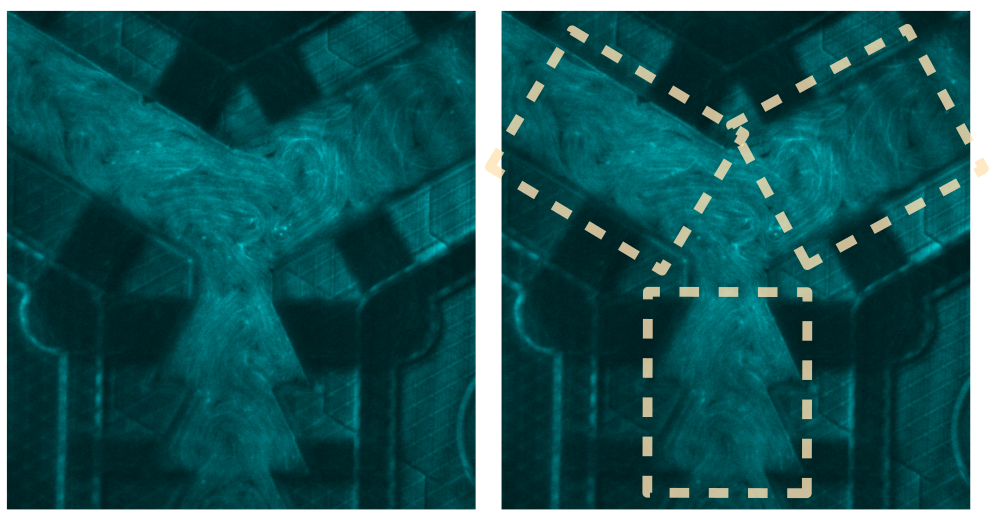

The above image (left) is an example microscopic view under a microscope. The bottom channel is modified with ratchet structures, and is therefore the inlet. The two branches on the top are the test channels. We want to measure the flow rate in the 3 channels separately. It's convenient to crop rectangular regions containing each branch, as shown in the right panel above. And then rotate the region to horizontal or vertical direction, so that the velocity along the channel direction is just the horizontal or vertical component of the measured velocity. 

In the following, let's write the code to crop the images. 

In [67]:
from skimage import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imutils import rotate
from matplotlib.patches import Rectangle
from myImageLib import readdata
import os

In [3]:
img = io.imread(r"test_files/crop-test.tif")

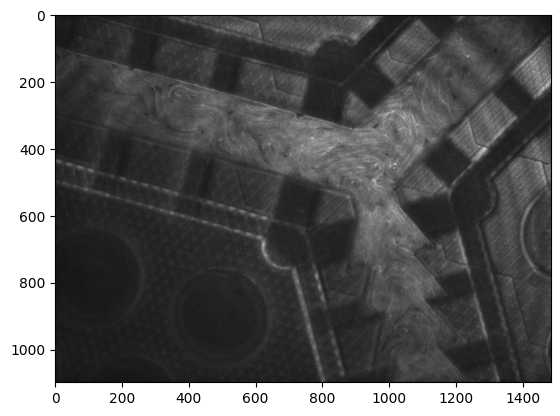

In [19]:
plt.imshow(img, cmap="gray")

The first step is to rotate the image, so that each channel have their +1 flow direction going up. This requires the knowledge of 3 rotation angle and 3 crop region coordinates after respective rotations. We start by mannually provide these numbers. <font color="red">Later on, we will develop more intelligent algorithm that crops the image more automatically.</font>

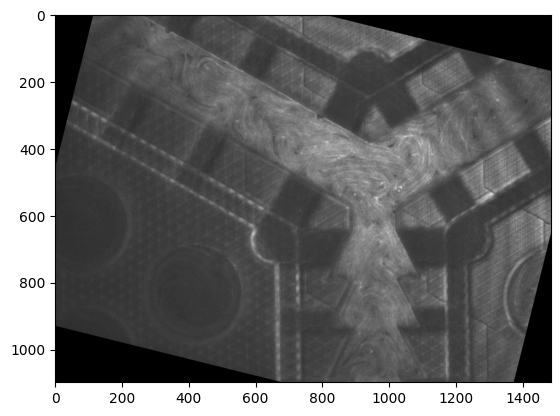

In [26]:
imgr = rotate(img, angle=-14)
plt.imshow(imgr, cmap="gray")

From ImageJ, we manually get 3 sets of (rotation angle, crop rectangle), saved in the "crop-data.csv" file as a table (picture below). Here, important information is the angle in odd lines and (BX, BY, Width, Height) in even lines. For example, to get the first crop of the inlet ratchet channel, we first rotate the raw image (angle[1]-90) degrees. Then, crop the resulting image using the rectangle cornered at (X, Y) with width and height (Width, Height) in the second line (2). 

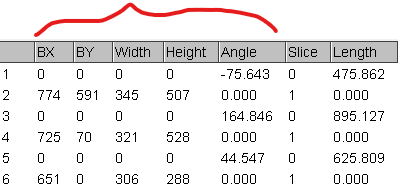

In [49]:
# load crop data from file
crop_data = pd.read_csv(r"test_files/crop-data.csv")
crop_data.head()

,,BX,BY,Width,Height,Angle,Slice,Length
0,1,0,0,0,0,104.357,0,475.862
1,2,774,591,345,507,0.000,1,0.000
2,3,0,0,0,0,164.846,0,895.127
3,4,725,70,321,528,0.000,1,0.000
4,5,0,0,0,0,44.547,0,625.809


In [50]:
# convert to angle, xy, wh
angle = 90 - crop_data.at[0, "Angle"]
x, y, w, h = crop_data.at[1, "BX"], crop_data.at[1, "BY"], crop_data.at[1, "Width"], crop_data.at[1, "Height"]

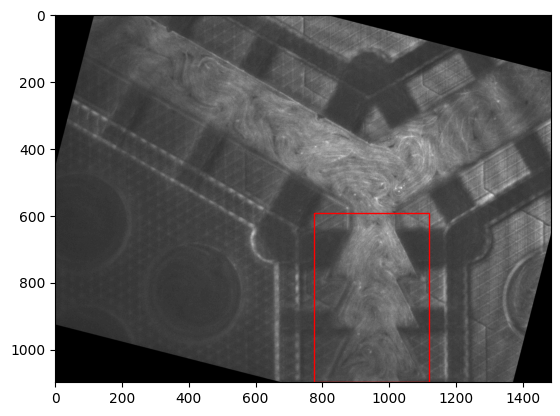

In [58]:
# show rotated image and crop region
imgr = rotate(img, angle=angle)
crop = imgr[y:y+h, x:x+w]
fig, ax = plt.subplots()
ax.imshow(imgr, cmap="gray")
rect = Rectangle((x, y), w, h, fill=False, ec="red")
ax.add_patch(rect)

Now, we write a function to preview all the crops. In this specific channel design, we will generate 3 crops from a single image. However, the function here should be compatible with arbitrary numbers of crops. 

In [61]:
def preview_crop(img, crop_data):
    """Preview the channel crops.
    Args:
    img -- raw image
    crop_data -- rotation angle and rectangle descriptor, generate manually from ImageJ
    """
    ncrops = len(crop_data) // 2
    img_in_row = 3
    nrows = ncrops // 3 + 1
    fig = plt.figure(figsize=(6, 2*nrows))
    
    for i in range(0, ncrops):
        angle = 90 - crop_data.at[2*i, "Angle"]
        x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
        imgr = rotate(img, angle=angle)
        crop = imgr[y:y+h, x:x+w]
        ax = fig.add_subplot(nrows, img_in_row, i+1)
        ax.imshow(crop, cmap="gray")

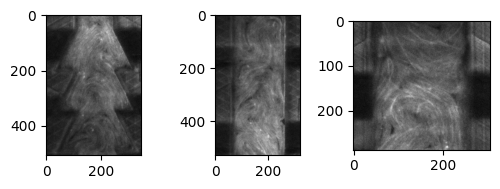

In [63]:
img = io.imread(r"test_files/crop-test.tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
preview_crop(img, crop_data)

Next, we write a function to crop an image sequence, using the same crop-data.

In [64]:
def crop_sequence(sequence, crop_data, save_folder):
    """Crop an image sequence and save the resulting crops into respective folder.
    Crop folders will be named 0, 1, 2 ...
    Args:
    sequence -- return value of readdata
    crop_data -- manually generated ImageJ rotation and crop data
    save_folder -- master folder to save cropped images"""
    ncrops = len(crop_data) // 2
    crop_folder = {}
    for i in range(ncrops):
        crop_folder[i] = os.path.join(save_folder, "crop-{:d}".format(i))
        if os.path.exists(crop_folder[i]) == False:
            os.makedirs(crop_folder[i])
    for num, item in sequence.iterrows():
        img = io.imread(item.Dir)
        name = item.Name
        for i in range(0, ncrops):
            angle = 90 - crop_data.at[2*i, "Angle"]
            x, y, w, h = crop_data.at[2*i+1, "BX"], crop_data.at[2*i+1, "BY"], crop_data.at[2*i+1, "Width"], crop_data.at[2*i+1, "Height"]
            imgr = rotate(img, angle=angle)
            crop = imgr[y:y+h, x:x+w]
            io.imsave(os.path.join(crop_folder[i], "{}.tif".format(name)), crop)

In [69]:
seq = readdata("test_files", "tif")
crop_data = pd.read_csv(r"test_files/crop-data.csv")
save_folder = r"test_files/cropped_images"
crop_sequence(seq, crop_data, save_folder)

C:\Users\liuzy\AppData\Local\Temp\ipykernel_17320\3232662655.py:22: UserWarning: test_files/cropped_images\crop-0\crop-test.tif is a low contrast image
  io.imsave(os.path.join(crop_folder[i], "{}.tif".format(name)), crop)
C:\Users\liuzy\AppData\Local\Temp\ipykernel_17320\3232662655.py:22: UserWarning: test_files/cropped_images\crop-1\crop-test.tif is a low contrast image
  io.imsave(os.path.join(crop_folder[i], "{}.tif".format(name)), crop)
C:\Users\liuzy\AppData\Local\Temp\ipykernel_17320\3232662655.py:22: UserWarning: test_files/cropped_images\crop-2\crop-test.tif is a low contrast image
  io.imsave(os.path.join(crop_folder[i], "{}.tif".format(name)), crop)
